In [65]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

# Data cleaning

In [66]:
#Read in income data
avg_house_prices = pd.read_csv('https://query.data.world/s/4YkmYcRnpcRqTmJ9qWn5KRALu157jX')
avg_house_prices = avg_house_prices[avg_house_prices['CountyName'] == 'San Diego'] 

#Extract zipcode, city, 2017-09 column
avg_house_prices = avg_house_prices[['RegionName', 'City', '2017-09']]
len(avg_house_prices)



79

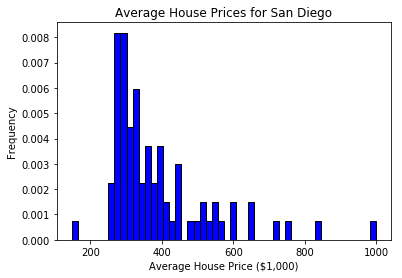

In [67]:
#Plot histogram of avg house prices
histogram = plt.hist(avg_house_prices['2017-09'], 50, edgecolor='black', facecolor='blue',normed=1)
plt.xlabel('Average House Price ($1,000)')
plt.ylabel('Frequency')
plt.title('Average House Prices for San Diego')

f1 = plt.gcf()

In [68]:
#Original df
df = pd.read_csv("resident_survey_weighted_datasd.csv")

#Create new df (data) that we will drop columns from
data = pd.read_csv("resident_survey_weighted_datasd.csv")

data.head()

,Num,Q1_1,Q1_2,Q1_3,Q1_4,Q1_5,Q1_6,Q2_1,Q2_2,Q2_3,...,Q25_1st,Q25_2nd,Q25_3rd,Q25_4th,Q25_5th,Q25_other,Q26,Q27,Q28,ZIP
0,1,5,4,4,3,3,3,4,5,3,...,3,NaN,NaN,NaN,NaN,NaN,2,2,7,92124
1,2,5,5,9,3,4,5,3,3,4,...,5,NaN,NaN,NaN,NaN,NaN,1,1,9,92115
2,3,4,3,4,4,4,5,4,4,4,...,1,NaN,NaN,NaN,NaN,NaN,1,1,9,92105
3,4,4,4,4,3,3,2,2,1,2,...,5,NaN,NaN,NaN,NaN,NaN,2,2,8,92102
4,5,5,5,5,4,5,5,5,5,4,...,3,NaN,NaN,NaN,NaN,NaN,2,2,4,92139


In [69]:
#Extract questions that ask residents to rate their satisfaction on a topic from 1-5
data.drop(data.columns[99:], axis=1, inplace=True)
data.drop(data.columns[0:7], axis=1, inplace=True)
#data.head(5)

data.drop(data.filter(like='Q4', axis=1), axis=1, inplace=True)
data.drop(data.filter(like='Q5', axis=1), axis=1, inplace=True)
data.drop(data.filter(like='Q10', axis=1), axis=1, inplace=True)
#data.head(5)

In [70]:
#Find total surveys submitted per zip code
total_zip = pd.DataFrame(df['ZIP'].value_counts())

#Only keep zipcodes who submitted more than 20 surveys
#total_zip = total_zip[total_zip['ZIP'] > 20]

#Convert total_zip to a dataframe, tell me if yall know a better way to do this
total_zip.index.name = 'x'
total_zip.reset_index(inplace=True)
total_zip.columns = ['ZIP', 'count']

#Add zipcode column back into data
data['ZIP'] = df['ZIP']

#Drop all rows whose zipcode has <20 surveys
data = data[data['ZIP'].isin(total_zip['ZIP'])].dropna()


In [71]:
#Find 20 questions with the lowest average rating
mean = data.mean()
bottom_10 = mean.nsmallest(n=11, keep='first')
print(bottom_10)


Q8_3      2.518369
Q3_8      2.519580
Q8_4      2.699233
Q8_10     2.750505
Q14_14    2.915220
Q8_7      3.018571
Q2_7      3.052887
Q8_8      3.073476
Q14_3     3.228906
Q8_2      3.300767
Q8_9      3.303593
dtype: float64


In [72]:
#Read in survey questions
questions = pd.read_csv("resident_survey_dictionary_datasd.csv")
#questions.head(5)


In [74]:
#Locate questions 
Q1 = (questions.loc[questions['question_number']=='Q8_3'])['question_text']
Q2 = (questions.loc[questions['question_number']=='Q3_8'])['question_text']
Q3 = (questions.loc[questions['question_number']=='Q8_4'])['question_text']
Q4 = (questions.loc[questions['question_number']=='Q8_10'])['question_text']
Q5 = (questions.loc[questions['question_number']=='Q14_14'])['question_text']
Q6 = (questions.loc[questions['question_number']=='Q8_7'])['question_text']
Q7 = (questions.loc[questions['question_number']=='Q2_7'])['question_text']
Q8 = (questions.loc[questions['question_number']=='Q8_8'])['question_text']
Q9 = (questions.loc[questions['question_number']=='Q14_3'])['question_text']
Q10 = (questions.loc[questions['question_number']=='Q8_2'])['question_text']
Q11 = (questions.loc[questions['question_number']=='Q8_9'])['question_text']


print(Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11)

54    Condition and maintenance of City streets
Name: question_text, dtype: object 23    Maintenance of City streets, sidewalks, and in...
Name: question_text, dtype: object 55    Condition and maintenance of streets in YOUR n...
Name: question_text, dtype: object 61    Quality of street repairs
Name: question_text, dtype: object 106    Quality/variety of entertainment, expositions,...
Name: question_text, dtype: object 58    Condition of sidewalks in the City
Name: question_text, dtype: object 14    Value that you receive for your City tax dolla...
Name: question_text, dtype: object 59    Condition of sidewalks in YOUR neighborhood
Name: question_text, dtype: object 95    Ease of obtaining permits from Development Ser...
Name: question_text, dtype: object 53    Availability of street lights in YOUR neighbor...
Name: question_text, dtype: object 60    Efforts to keep streets clean (i.e., street sw...
Name: question_text, dtype: object


In [97]:
#Extract street questions and zipcodes out of the top 10 
street_qs = data[['Q8_3', 'Q3_8', 'Q8_4', 'Q8_10', 'Q8_7', 'Q8_8', 'Q8_2', 'Q8_9', 'ZIP']]
street_qs

,Q8_3,Q3_8,Q8_4,Q8_10,Q8_7,Q8_8,Q8_2,Q8_9,ZIP
0,3,2,3,3,3,4,4,4,92124
1,3,2,4,3,3,1,3,2,92115
2,2,3,2,2,3,2,3,4,92105
3,4,4,4,4,4,4,1,4,92102
4,3,3,3,3,3,3,3,3,92139
5,5,5,5,5,5,5,5,5,92101
6,1,1,1,9,1,1,3,2,99999
7,4,4,4,4,4,4,4,4,92131
8,2,4,2,2,4,4,2,4,92117
9,1,2,2,2,2,2,2,2,92114


In [87]:
#Find average rating on all questions for each zip code

avg_ratings_per_zip = street_qs.groupby('ZIP', as_index=False).mean()
#avg_ratings_per_zip.head()

#FOR GEOGRAPH: Extract 5 zipcodes with lowest average rating
lowest_q83 = avg_ratings_per_zip.nsmallest(n=5, columns='Q8_3',keep='first')[['ZIP','Q8_3']]
lowest_q38 = avg_ratings_per_zip.nsmallest(n=5, columns='Q3_8',keep='first')[['ZIP','Q3_8']]
lowest_q84 = avg_ratings_per_zip.nsmallest(n=5, columns='Q8_4',keep='first')[['ZIP','Q8_4']]
lowest_q810 = avg_ratings_per_zip.nsmallest(n=5, columns='Q8_10',keep='first')[['ZIP','Q8_10']]
lowest_q87 = avg_ratings_per_zip.nsmallest(n=5, columns='Q8_7',keep='first')[['ZIP','Q8_7']]
lowest_q88 = avg_ratings_per_zip.nsmallest(n=5, columns='Q8_8',keep='first')[['ZIP','Q8_8']]
lowest_q82 = avg_ratings_per_zip.nsmallest(n=5, columns='Q8_2',keep='first')[['ZIP','Q8_2']]
lowest_q89 = avg_ratings_per_zip.nsmallest(n=5, columns='Q8_9',keep='first')[['ZIP','Q8_9']]


In [84]:
#Add avg house prices 2017-09 data to ratings data
rating_and_price = avg_ratings_per_zip.merge(avg_house_prices, left_on='ZIP', right_on='RegionName')

#Compute correlation between avg rating and avg house price for each question
Q8_3_corr = rating_and_price['Q8_3'].corr(rating_and_price['2017-09'])
Q3_8_corr = rating_and_price['Q3_8'].corr(rating_and_price['2017-09'])
Q8_4_corr = rating_and_price['Q8_4'].corr(rating_and_price['2017-09'])
Q8_10_corr = rating_and_price['Q8_10'].corr(rating_and_price['2017-09'])
Q8_7_corr = rating_and_price['Q8_7'].corr(rating_and_price['2017-09'])
Q8_8_corr = rating_and_price['Q8_8'].corr(rating_and_price['2017-09'])
Q8_2_corr = rating_and_price['Q8_2'].corr(rating_and_price['2017-09'])
Q8_9_corr = rating_and_price['Q8_9'].corr(rating_and_price['2017-09'])
print(Q8_3_corr,Q3_8_corr,Q8_4_corr,Q8_10_corr,Q8_7_corr,Q8_8_corr,Q8_2_corr,Q8_9_corr)



-0.037873060765 -0.145403166273 0.0752164084134 0.0994608716216 -0.397213847014 -0.155456091164 0.094477669395 -0.047194082813


Text(0.5,1,'Satisfaction with Condition/Maintenance of SD Streets vs. Average House Price')

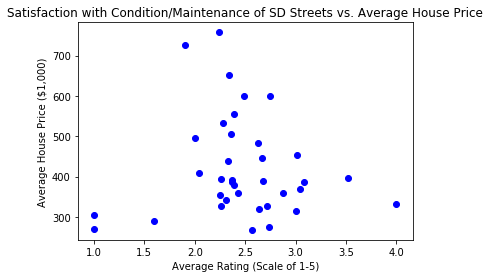

In [94]:
#Plot scatterplot of avg rating vs avg house price
Q8_3_scatter = plt.scatter(rating_and_price['Q8_3'], rating_and_price['2017-09'], c='blue')
plt.xlabel('Average Rating (Scale of 1-5)')
plt.ylabel('Average House Price ($1,000)')
plt.title('Satisfaction with Condition/Maintenance of SD Streets vs. Average House Price')


Text(0.5,1,'Satisfaction with Maintenance of SD Streets/Sidewalks/Infrastructure vs Avg House Price')

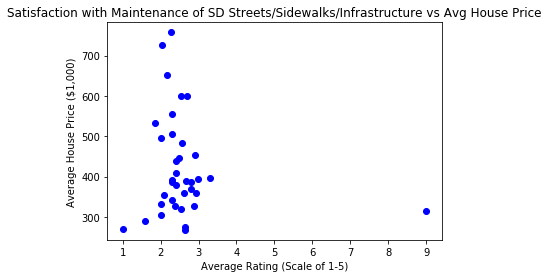

In [96]:
Q3_8_scatter = plt.scatter(rating_and_price['Q3_8'], rating_and_price['2017-09'], c='blue')
plt.xlabel('Average Rating (Scale of 1-5)')
plt.ylabel('Average House Price ($1,000)')
plt.title('Satisfaction with Maintenance of SD Streets/Sidewalks/Infrastructure vs Avg House Price')

In [ ]:
Q3_8_scatter = plt.scatter(rating_and_price['Q8_4'], rating_and_price['2017-09'], c='blue')
plt.xlabel('Average Rating on Q8_4')
plt.ylabel('Average House Price ($1,000)')
plt.title('Average Rating on Q8_4 vs. Average House Price')

In [58]:
#Extract Q3_8 (Maintenance of City streets, sidewalks, and infrastructure)
Q3_8 = pd.DataFrame(data.loc[:,'Q3_8'])
Q3_8['ZIP'] = data['ZIP']

#Find average rating on Q8_3 per zip code
avg_ratings_per_zip_q38 = Q3_8.groupby('ZIP', as_index=False)['Q3_8'].mean()

#Extract 5 zipcodes with lowest average rating
lowest_q38 = avg_ratings_per_zip_q38.nsmallest(n=5, columns='Q3_8', keep='first')
lowest_q38

,ZIP,Q3_8
1,91915,1.0
8,92093,1.0
44,93154,1.0
45,98764,1.0
0,91910,1.6


In [ ]:
#Create dataframe with zipcode, average rating for Q3_8, and avg house prices 2017-09
Q8_3_rating_price = avg_ratings_per_zip_q83.merge(avg_house_prices, left_on='ZIP', right_on='RegionName')
Q8_3_rating_price = Q8_3_rating_price[['ZIP','Q8_3', '2017-09']]
Q8_3_rating_price.set_index('ZIP', inplace=True)

#Compute correlation between avg rating and avg house price
Q8_3_corr = Q8_3_rating_price.corr()
Q8_3_corr

In [114]:
#Extract Q8_4 (Quality of street repairs)
Q8_4 = pd.DataFrame(data.loc[:,'Q8_4'])
Q8_4['ZIP'] = data['ZIP']

#Find average rating on Q8_3 per zip code
avg_ratings_per_zip_q84 = Q8_4.groupby('ZIP', as_index=False)['Q8_4'].mean()

#Extract 5 zipcodes with lowest average rating
lowest_q84 = avg_ratings_per_zip_q84.nsmallest(n=5, columns='Q8_4', keep='first')
print(lowest_q84)


      ZIP      Q8_4
3   91945  1.000000
4   91950  1.000000
7   92081  1.000000
8   92093  1.000000
17  92109  1.921348
